In [138]:
import matplotlib.pyplot as plt
from graphviz import Source
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [139]:
import warnings
warnings.filterwarnings("ignore")

In [140]:
import pandas as pd
import numpy as np
import catboost
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
import imblearn
import xgboost
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV

In [141]:
transactions = pd.read_csv('hits0712.csv')
features = pd.read_csv('features.csv')
features.index = features['Unnamed: 0']
features = features.drop('Unnamed: 0', axis = 1)

In [142]:
transactions

Unnamed: 0                          event_id    user_id  rec_user_id  \
0              5  0fcea7fec4ff479cac8cf37b4555c817   75301207     49913000   
1              6  c29a4e64d27b435b9b55aa3e62ce54d4    1200695     12797310   
2              8  3107b2b1afcb490ab0a31135eb4b386c   45657780     23814017   
3             10  d9bc95d991144d53b950d8084fa846bf   21683486      9865131   
4             22  9fc959da4cd144ea8bf5bae2dc041a5e    4531894  VSP15472255   
...          ...                               ...        ...          ...   
9011       23682  28ea1a08c79240449922d5756646a353   92237374     69162645   
9012       23683  65a5b1dd74564e99b3b3c39b9ee460f7    3316389     89796796   
9013       23684  df808870913643c7ba24e990e6bbea39   24338601     58490342   
9014       23685  de1b30f52c264e95816e0cc163b2c116    2000352     37033043   
9015       23693  c03f385560d54ae685ba6d7c5a2ad50a  102617826     34882458   

                date_time resolution sub_channel  
0     2018-12-07 07:56:49          G      ATMAPI  
1     2018-12-07 07:14:41          G   MOBILEAPI  
2     2018-12-07 14:02:30          G   MOBILEAPI  
3     2018-12-07 10:32:41          G      WEBAPI  
4     2018-12-07 18:22:52          G   MOBILEAPI  
...                   ...        ...         ...  
9011  2018-12-07 17:46:35          G   MOBILEAPI  
9012  2018-12-07 18:42:47          G      WEBAPI  
9013  2018-12-07 13:55:59          G   MOBILEAPI  
9014  2018-12-07 17:55:32          G      ATMAPI  
9015  2018-12-07 06:33:06          G      ATMAPI  

[9016 rows x 7 columns]

In [143]:
feature_columns = ['mu1','std1','mu2','std2']
for num in ['1','2']:
    for intr in ['own interval', 'genue interval', 'fraud interval', 'rec fraud interval']:
        for alpha in ['0.9', '0.8', '0.7', '0.6']:
            for hits in ['5', '10']:
                feature_columns.append(num+' in '+intr+alpha+' '+hits)
for num in ['1','2']:
    for hmm in ['genue hmm likehood time', 'fraud hmm likehood time', 'rec fraud hmm likehood time']:
        feature_columns.append(num+hmm)
for num in ['1','2']:
    for hmm in ['genue hmm likehood amount', 'fraud hmm likehood amount', 'rec fraud hmm likehood amount']:
        feature_columns.append(num+hmm)
feature_columns.append('ATMAPI')
feature_columns.append('MOBILEAPI')
feature_columns.append('WEBAPI')

In [144]:
enc = OneHotEncoder(sparse=False)
sub_chan = enc.fit_transform(transactions.iloc[features.index].sub_channel.values.reshape((-1,1)))

In [145]:
sub_chan = pd.DataFrame(sub_chan)
sub_chan.index = features.index
features = pd.concat([features, sub_chan], axis =1)

In [146]:
features.columns = list(range(83))
features.isna().sum()[features.isna().sum()>0]

1    3
3    3
dtype: int64

In [147]:
features[[1,3]][transactions.resolution!='G'].isna().sum()

1    0
3    0
dtype: int64

In [148]:
features = features.fillna(0)

In [149]:
target = transactions.resolution.apply(lambda x: 1 if x != 'G' else 0).iloc[features.index]

In [150]:
features.columns = feature_columns
features.head()

ch_features = features.drop(feature_columns[:12]+feature_columns[36:44], axis =1)

### Уменьшим количество элементов класса 0, увеличим класс 1, оставив в итоге 20% фрода

In [151]:
X_und, y_und = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.01).fit_resample(features, target)
X_os, y_os = imblearn.over_sampling.ADASYN(sampling_strategy=0.2).fit_resample(X_und, y_und)

In [152]:
vis_mod = TSNE().fit_transform(X = features)

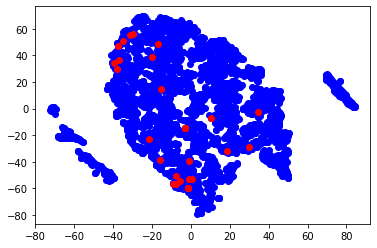

In [153]:
plt.scatter(vis_mod[target==0][:,0], vis_mod[target==0][:,1], c='b')
plt.scatter(vis_mod[target==1][:,0], vis_mod[target==1][:,1], c='r')
plt.show()

### Теперь обучаем

In [154]:
tr = tree.ExtraTreeClassifier().fit(features,target)

In [155]:
from IPython.display import SVG

In [156]:
import graphviz

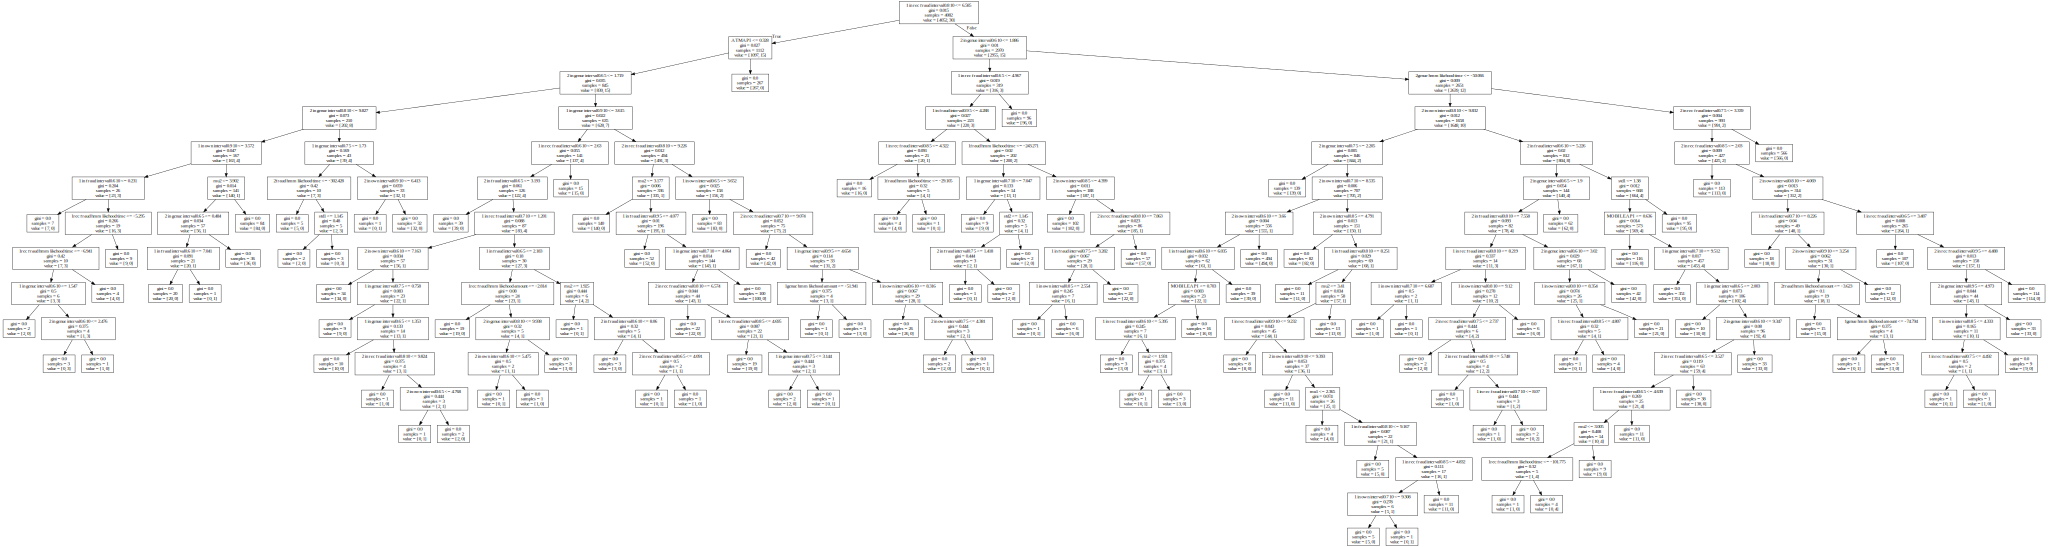

In [157]:
graph = Source( tree.export_graphviz(tr, out_file=None, feature_names=feature_columns))
SVG(graph.pipe(format='svg'))

In [158]:
print('crossvalidation with recall on catboost is',
      cross_val_score(catboost.CatBoostClassifier(verbose=0),X_os,y_os, scoring = metrics.make_scorer(metrics.recall_score)))
print('crossvalidation with precision on catboost is',
      cross_val_score(catboost.CatBoostClassifier(verbose=0),X_os,y_os, scoring = metrics.make_scorer(metrics.precision_score)))

crossvalidation with recall on catboost is [0.85279188 0.93401015 0.90862944]
crossvalidation with precision on catboost is [1. 1. 1.]


In [162]:
cat_model = catboost.CatBoostClassifier(verbose=0).fit(X_os,y_os,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [163]:
pr, rc, th = metrics.precision_recall_curve(target, cat_model.predict_proba(features)[:,1])

In [164]:
pr

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [165]:
rc

array([1.        , 0.96666667, 0.93333333, 0.9       , 0.86666667,
       0.83333333, 0.8       , 0.76666667, 0.73333333, 0.7       ,
       0.66666667, 0.63333333, 0.6       , 0.56666667, 0.53333333,
       0.5       , 0.46666667, 0.43333333, 0.4       , 0.36666667,
       0.33333333, 0.3       , 0.26666667, 0.23333333, 0.2       ,
       0.16666667, 0.13333333, 0.        ])

In [107]:
th

array([0.81248095, 0.84094815, 0.85618447, 0.8633278 , 0.87417819,
       0.87545607, 0.87814947, 0.89045009, 0.89132463, 0.90012331,
       0.90376375, 0.9074195 , 0.90853433, 0.90879213, 0.91582309,
       0.91817869, 0.91904293, 0.9290581 , 0.93420839, 0.94943412,
       0.94992747, 0.951909  , 0.95410803, 0.95929078, 0.96133983,
       0.96149716, 0.96454104, 0.97605088, 0.98500975, 0.99152357])

In [122]:
X_und1, y_und1 = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.01).fit_resample(ch_features, target)
X_os1, y_os1 = imblearn.over_sampling.ADASYN(sampling_strategy=0.2).fit_resample(X_und1, y_und1)

In [123]:
print('crossvalidation with recall on catboost is',
      cross_val_score(catboost.CatBoostClassifier(verbose=0),X_os1,y_os1, scoring = metrics.make_scorer(metrics.recall_score)))
print('crossvalidation with precision on catboost is',
      cross_val_score(catboost.CatBoostClassifier(verbose=0),X_os1,y_os1, scoring = metrics.make_scorer(metrics.precision_score)))

crossvalidation with recall on catboost is [0.87677725 0.92417062 0.94761905]
crossvalidation with precision on catboost is [1.         0.99489796 1.        ]


In [127]:
cat_model.calc_feature_statistics(features, target=target)

{'0': {'borders': array([0.6882037, 1.9424105, 2.0636518, 2.2363625, 2.2552254, 2.2646613,
         2.2755394, 2.2917595, 2.303503 , 2.3167686, 2.3338366, 2.3513632,
         2.3642027, 2.3727179, 2.3933063, 2.4253457, 2.604583 , 2.744575 ,
         2.7639542, 2.7753444, 2.789591 , 2.8088403, 2.8364797, 2.908018 ,
         2.94206  , 3.0180461, 3.1249871, 3.1610384, 3.1758685, 3.189217 ,
         3.3071313, 3.3195875, 3.3730936, 3.4950924, 3.527202 , 3.6711903,
         3.702785 , 3.7325592, 3.7569299, 3.7661705, 3.7874699, 3.802526 ,
         4.1250057, 4.283519 , 4.3045435, 4.3642254, 4.400937 , 4.432369 ,
         4.482598 , 4.6865225, 5.1762624, 5.7091665], dtype=float32),
  'binarized_feature': array([38, 25, 27, ..., 14,  2, 42]),
  'mean_target': array([0.        , 0.00396825, 0.01123596, 0.        , 0.        ,
         0.        , 0.        , 0.1       , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.00328947

In [166]:
dict(zip(feature_columns, cat_model.feature_importances_))

sorted(dict(zip(feature_columns, cat_model.feature_importances_)).items(), key=lambda x:x[1], reverse=True)

[('1 in own interval0.9 5', 4.172089693632443),
 ('1 in genue interval0.8 5', 3.9340515279150354),
 ('mu2', 3.7214593788226615),
 ('MOBILEAPI', 3.5709639871252317),
 ('1 in rec fraud interval0.9 5', 3.43083708141266),
 ('2rec fraud hmm likehood amount', 3.414879556306233),
 ('2 in fraud interval0.7 5', 3.2902832329863307),
 ('2 in rec fraud interval0.6 10', 2.7305934528009606),
 ('2 in rec fraud interval0.6 5', 2.200124554873761),
 ('2 in own interval0.7 10', 2.1177472224023743),
 ('2fraud hmm likehood time', 2.071156242723372),
 ('1 in rec fraud interval0.8 10', 1.944108990762306),
 ('1 in own interval0.7 10', 1.917989826886358),
 ('std2', 1.9124183989502872),
 ('2genue hmm likehood time', 1.8304055310876095),
 ('2fraud hmm likehood amount', 1.7661422826532425),
 ('1 in fraud interval0.8 5', 1.711462492638859),
 ('1 in genue interval0.6 5', 1.7006586517755826),
 ('2 in own interval0.8 5', 1.6719344319139504),
 ('1 in rec fraud interval0.8 5', 1.6520490988995329),
 ('1 in rec fraud int